<a href="https://colab.research.google.com/github/renatampr/https-github.com-renatampr-topicos_contemporaneos--CESAR-EAD-2024/blob/main/RENATA_06_Improving_the_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Aluna: Renata Pereira rmbp@cesar.school


In [36]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [37]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-12-18 13:59:25--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv.1’

mnist_train.csv.1   100%[===================>] 104.50M  35.1MB/s    in 3.0s    

2024-12-18 13:59:28 (35.1 MB/s) - ‘data/mnist_train.csv.1’ saved [109575994/109575994]



In [38]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [39]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [40]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [41]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [42]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [43]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [45]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:01<00:00, 10.04it/s]


Epoch 1, Train Loss: 2.315, Train Accuracy: 13.80%
Epoch 1, Val Loss: 2.238, Val Accuracy: 17.20%


100%|██████████| 16/16 [00:00<00:00, 17.22it/s]


Epoch 2, Train Loss: 2.130, Train Accuracy: 25.20%
Epoch 2, Val Loss: 1.899, Val Accuracy: 43.80%


100%|██████████| 16/16 [00:00<00:00, 21.16it/s]


Epoch 3, Train Loss: 1.566, Train Accuracy: 47.20%
Epoch 3, Val Loss: 1.109, Val Accuracy: 67.60%


100%|██████████| 16/16 [00:00<00:00, 21.30it/s]


Epoch 4, Train Loss: 0.992, Train Accuracy: 66.30%
Epoch 4, Val Loss: 0.713, Val Accuracy: 75.40%


100%|██████████| 16/16 [00:00<00:00, 21.20it/s]


Epoch 5, Train Loss: 0.695, Train Accuracy: 77.50%
Epoch 5, Val Loss: 0.514, Val Accuracy: 82.00%
Treinamento concluído


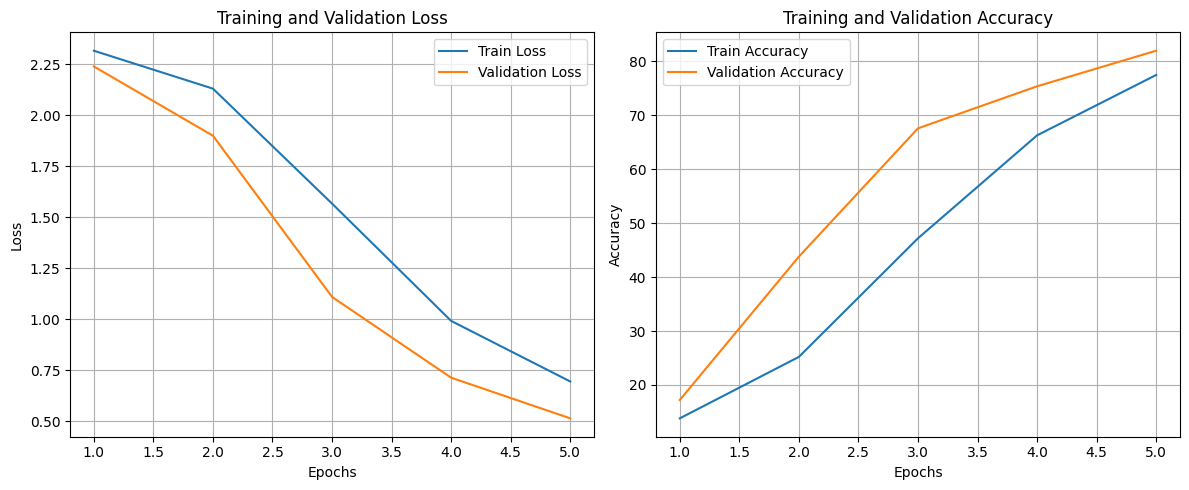

In [46]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_model(model, testloader)

## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [47]:
class CNN(nn.Module):
    def __init__(self, num_filter_1=6, num_filter_2=12,initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filter_1, 5)
        self.conv2 = nn.Conv2d(num_filter_1, num_filter_2, 5)
        self.fc1 = nn.Linear(num_filter_2 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [48]:
#parameters_combinations = [(2,4), (2,16), (8,4),(8,16)]
parameters_combinations = [(6,8),(12,16)]

for num_filters_1, num_filters_2 in parameters_combinations:
    model = CNN(
        num_filter_1=num_filters_1,
        num_filter_2=num_filters_2,
        initialize_weights=True,
        dropout=0.2
    )

model = CNN(
    initialize_weights=True,
    dropout=0.2
)



In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)



In [50]:
history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )



100%|██████████| 16/16 [00:00<00:00, 20.60it/s]


Epoch 1, Train Loss: 2.286, Train Accuracy: 15.30%
Epoch 1, Val Loss: 2.211, Val Accuracy: 31.40%


100%|██████████| 16/16 [00:00<00:00, 21.11it/s]


Epoch 2, Train Loss: 2.095, Train Accuracy: 29.40%
Epoch 2, Val Loss: 1.821, Val Accuracy: 46.20%


100%|██████████| 16/16 [00:00<00:00, 20.60it/s]


Epoch 3, Train Loss: 1.445, Train Accuracy: 53.10%
Epoch 3, Val Loss: 0.828, Val Accuracy: 76.00%


100%|██████████| 16/16 [00:00<00:00, 21.04it/s]


Epoch 4, Train Loss: 0.858, Train Accuracy: 70.70%
Epoch 4, Val Loss: 0.585, Val Accuracy: 81.00%


100%|██████████| 16/16 [00:00<00:00, 21.34it/s]


Epoch 5, Train Loss: 0.619, Train Accuracy: 78.90%
Epoch 5, Val Loss: 0.464, Val Accuracy: 85.40%
Treinamento concluído


In [51]:
test_model(model, testloader)
print()

Acurácia da rede na base de teste: 86.20%



### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [52]:
for i in range(5):
     num_neurons = np.random.randint(10, 100)
     model = model
     criterion = criterion
     optimizer = optimizer
     history = history

     print(f'Número de neurônios na camada fully connected: {num_neurons}')


Número de neurônios na camada fully connected: 55
Número de neurônios na camada fully connected: 78
Número de neurônios na camada fully connected: 90
Número de neurônios na camada fully connected: 61
Número de neurônios na camada fully connected: 20
